# **PREVIOUS STEPS**

## Libraries/Software
All the libraries and software needed during the whole code.

In [ ]:
# Install Software
"""
WFDB Library:
This is a set of functions (subroutines) for reading and writing files in the formats used by PhysioBank databases (among others).
Software for viewing, analyzing, and creating recordings of physiologic signals.
"""
!pip install wfdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
import wfdb
import ast
import matplotlib.pyplot as plt
import os
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sys
import seaborn as sns
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OutputCodeClassifier
from sklearn.multioutput import MultiOutputClassifier
from  sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import pipeline
from sklearn.metrics import accuracy_score
from copy import deepcopy


## Google Drive mounting
Thanks to Google drive mounting, you can interact with your Drive files in the file browser side panel or using command-line utilities.
You can mount your Google Drive files by running the following code snippet.




In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#**DATA SCIENCE TASK** 
During this task we will see how to:

*   Read the ECG files and corresponding annotations
*   Show how they will work on the signal and plot the signal in appropriate manner to be read by a doctor
*   Identify the heart beat of the signal, average and total heart beat in the signal
*   Identify the complex QRS in the signal and been able to annotate on it

## Read ECG files


Functions from ***example_physionet.py*** in

*Wagner, P., Strodthoff, N., Bousseljot, R., Samek, W., & Schaeffter, T. (2022). PTB-XL, a large publicly available electrocardiography dataset (version 1.0.3). PhysioNet. [Link](https://doi.org/10.13026/kfzx-aw45)*


*   *load_raw_data*, function used to load the raw signals from 12 lead ECG.
*   *aggregate_diagnostic*, functino to add the diagnostic to the data frame where it is saved all the info related to each ECG signal.


In [ ]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

Load raw ECG signal and annotations from CSV located on Google Drive.

Data from ***Physionet***


*Wagner, P., Strodthoff, N., Bousseljot, R., Samek, W., & Schaeffter, T. (2022). PTB-XL, a large publicly available electrocardiography dataset (version 1.0.3). PhysioNet. [Link](https://doi.org/10.13026/kfzx-aw45)*

In [ ]:
# Path where I have all the data from PTB-XL (Physionet) saved
path = '/content/drive/MyDrive/IDOVEN/Data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/'

# I have decided to work with 100Hz as sampling rate to reduce time
sampling_rate=100

# Load and convert annotation data from the ptbxl_database.csv excel
Y_original = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y_original.scp_codes = Y_original.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

# We add the supperclass of each diagnostic to the data frame to have all the information together
Y_original['diagnostic_superclass'] = Y_original.scp_codes.apply(aggregate_diagnostic) # Apply diagnostic superclass

In [ ]:
# We will eliminate those signals without diagnostic
index_to_eliminate = Y_original['diagnostic_superclass'].map(lambda d: len(d)) > 0
Y_original = Y_original[index_to_eliminate]

In [ ]:
# counting unique items
item_counts = Y_original["diagnostic_superclass"].value_counts()
print(item_counts)

[NORM]                 9072
[MI]                   2532
[STTC]                 2401
[CD]                   1708
[MI, CD]               1300
[HYP, STTC]             781
[MI, STTC]              600
[HYP]                   535
[CD, STTC]              471
[CD, NORM]              407
[MI, HYP, STTC]         361
[HYP, CD]               300
[MI, CD, STTC]          223
[HYP, CD, STTC]         211
[MI, HYP]               183
[MI, HYP, CD, STTC]     156
[MI, HYP, CD]           117
[STTC, NORM]             28
[CD, STTC, NORM]          5
[HYP, CD, NORM]           2
[HYP, NORM]               2
[MI, HYP, CD, NORM]       1
Name: diagnostic_superclass, dtype: int64


In [ ]:
# We have decided to start by working only classifying the following illness: STTC, CD and MI versus Normal. 
for diagnostic, index in zip(Y_original["diagnostic_superclass"], Y_original.index.values):
  if diagnostic == ['NORM'] or diagnostic == ['STTC'] or diagnostic == ['CD'] or diagnostic == ['MI']:
    pass
  else:
    Y_original = Y_original.drop(index)

In [ ]:
Y_short = Y_original[1:1000]

In [ ]:
# counting unique items
item_counts = Y_short["diagnostic_superclass"].value_counts()
print(item_counts)

[NORM]    685
[STTC]    137
[CD]       98
[MI]       79
Name: diagnostic_superclass, dtype: int64


In [ ]:
# Load ECG data we are interested in:
ecg_raw_short = load_raw_data(Y_short, sampling_rate, str(path) + '/')

## Identify hearth beat and QRS complex

### Pan Tompinks 

The Pan and Tompkins algorithm consists on various steps of signal processing to detect the R-Peak detection and consequently the hearth rate. 

As it is shown in the image below, it consists on the following steps to preproces the signal. 

1.   *Band Pass Filter*, a combination of a high pass filter and low pass filter to eliminate the noise (as for example muscle contrations).
2.   *Derivative*. 
3.   *Squaring*.
4. *Moving window integration*.



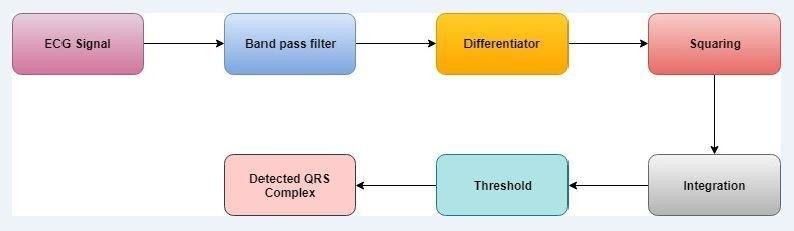


Figure 1. Tom and Hopkins Steps

Once the signal is preprocessed we can pass to thresholding and detect the differnt signal peaks (PQRST).

At first, in order to know the number of beats, we evaluate the all the peaks that exceeds the mean value of the normalized ECG (R peaks).

Once we know the number of beats that are present on the signal we can start by finding the other peaks as it is show in below image.


*   R peak, highest value from the left to the right 
*   Q peak, min value between the left and the R peak
*   S peak, min value between the R peal and the right 
*   P peak, max value between the left and the Q peak
*   T peak, max value between the S peak and the right 

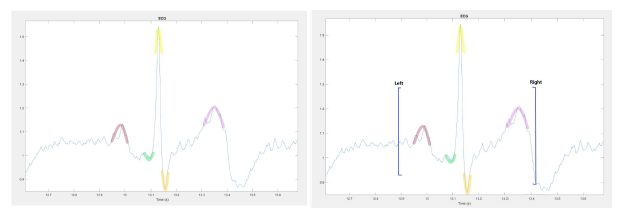

Figure 2. ECG signal, each color makes reference to one peak (Red, P; Gree, Q; Yellow, R; Orange, S; Pink, T).

#### Function

In [ ]:
class Pan_Tompkins_QRS():

  def low_pass_filter(self, signal):
    '''
    Low Pass Filter
    :param signal: input signal
    :return: processed signal

    '''
    low_pass_signal = signal.copy()
    for time in time_stamp:
      curr = signal[time] 

      if (time >= 1):
        curr += 2*low_pass_signal[time-1]

      if (time >= 2):
        curr -= low_pass_signal[time-2]

      if (time >= 6):
        curr -= 2*signal[time-6]
      
      if (time >= 12):
        curr += signal[time-12]

      low_pass_signal[time] = curr
    low_pass_signal = low_pass_signal/ max(abs(low_pass_signal))
    return low_pass_signal

  def high_pass_filter(self, signal):
    '''
    High Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    '''

    high_pass_signal = signal.copy()

    for time in time_stamp:
      curr = -1*signal[time]

      if (time >= 16):
        curr += 32*signal[time-16]

      if (time >= 1):
        curr -= high_pass_signal[time-1]

      if (time >= 32):
        curr += signal[time-32]

      high_pass_signal[time] = curr 
    high_pass_signal = high_pass_signal/max(abs(high_pass_signal))
    return high_pass_signal

  def band_pass_filter(self,signal):
    '''
    Band Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    A bandpass filter is created by a combination of a high pass filter and a low pass filter. 
    The signal is first filtered with a low pass filter and the output of the low pass filter
    is given to a high pass filter. The function of the filter is to eliminate
    noise due to muscle contractions, T-waves, or any other noise present in the data. The implementation 
    is on the lines with Pan Tompkin's research paper 
    '''
    low_pass_signal = self.low_pass_filter(signal)
    band_pass_signal = self.high_pass_filter(low_pass_signal)

    return band_pass_signal

  
  def derivative(self,signal):
    '''
    Derivative Filter 
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    The implementation is as given in the research paper. It is used 
    to get the slope information for the QRS complex. It takes the 
    filtered signal as an input. 
    '''
    T = 1/fs
    derivative_signal = signal.copy()

    for time in time_stamp:
      curr = 0

      if (time >= 2):
        curr -= signal[time-2]

      if (time >= 1):
        curr -= 2*signal[time-1]
        
      if (time < len(time_stamp)-1):
        curr += 2*signal[time+1]

      if (time < len(time_stamp)-2):
        curr += signal[time+2]
      derivative_signal[time] = (curr/(8*T))
    
    return derivative_signal

  def squaring(self,signal):
    '''
    Squaring the Signal
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    This just squares all the values in the waveform. It provides a non-linear amplification
    to the higher frequency components of QRS complexes in the derivative signal. 
    '''
    return np.square(signal)


  def moving_window_integration(self,signal):
    '''
    Moving Window Integrator
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    It is a kind of running average within a window of certain size. Here I took a window 
    of 0.15 seconds. This basically serves as a tool for detection and finding features
    of QRS complexes and R peaks.
    '''
    WINDOW_SIZE = 0.15*fs
    moving_window_signal = signal.copy()
    for time in time_stamp:
      index = 0
      curr = 0
      while (index < WINDOW_SIZE):
        if (time < index):
          break
        curr += signal[time-index]
        index += 1

      moving_window_signal[time] = curr/index
    return moving_window_signal

  def solve(self,signal):
    '''
    Solver, Combines all the above functions
    :param signal: input signal
    :return: prcoessed signal

    First the signal is filtered using a band pass filter, then passed in a differentiator
    followed by square wave generator, and then into a moving window integrator. The final signal is
    returned to to the caller.
    '''

    band_pass_signal = self.band_pass_filter(signal.copy())
    derivative_signal = self.derivative(band_pass_signal.copy())
    square_signal = self.squaring(derivative_signal.copy())
    moving_window_avg_signal = self.moving_window_integration(square_signal.copy())

    return moving_window_avg_signal,band_pass_signal, derivative_signal, square_signal

Funtion to detect peaks and consequently detect hearth beat.  

In [ ]:
def detect_peaks(ecg_signal, fs): 
    # Initialization of variables

    possible_peaks = []
    signal_peaks = []
    r_peaks = []
    # running estimate of the signal peak
    SPKI = 0
    # running estimate of the signal peak
    SPKF = 0
    # running estimate of the noise peak
    NPKI = 0
    # running estimate of the noise peak
    NPKF = 0
    rr_avg_one = []
    # First Integrated result threshold
    THRESHOLDI1 = 0
    # First Filtered result threshold
    THRESHOLDF1 = 0
    rr_avg_two = []
    # Second Integrated result threshold
    THRESHOLDI2 = 0
    # Second Filtered result threshold
    THRESHOLDF2 = 0
    # T wave detection flag
    is_T_found = 0
    # A search window of samples corresponding to 0.15 seconds
    window = round(0.15 * fs)            

    # Stage I: Fudicial Mark possible_peaks on the integrated signal
    FM_peaks = []
    # Smoothening the integration signal
    integration_signal_smooth = np.convolve(integration_signal, np.ones((20,)) / 20, mode = 'same')    
    localDiff = np.diff(integration_signal_smooth)
    # finding local maxima using difference array and ignoring
    # possible_peaks before initialization step i.e before fs

    for i in range(1,len(localDiff)):
        if i-1 > 2*fs and localDiff[i-1] > 0 and localDiff[i] < 0 :
            FM_peaks.append(i-1)           

    # Find out the possbile peaks for all the local maximas
    for index in range(len(FM_peaks)):

        # Finding maximum value position in the current search window
        current_peak = FM_peaks[index]
        left_limit = max(current_peak-window, 0) 
        right_limit = min(current_peak+window+1, len(band_pass_signal))
        max_index = -1
        max_value = -sys.maxsize
        for i in range(left_limit, right_limit):
            if(band_pass_signal[i] > max_value):
                max_value = band_pass_signal[i]
                max_index = i
        if (max_index != -1):
            possible_peaks.append(max_index)

        if (index == 0 or index > len(possible_peaks)):
          # if first peak
          if (integration_signal[current_peak] >= THRESHOLDI1): 
              SPKI = 0.125 * integration_signal[current_peak]  + 0.875 * SPKI
              if possible_peaks[index] > THRESHOLDF1:                                            
                  SPKF = 0.125 * band_pass_signal[index] + 0.875 * SPKF 
                  signal_peaks.append(possible_peaks[index])                             
              else:
                  NPKF = 0.125 * band_pass_signal[index] + 0.875 * NPKF                                    
              
          elif ( (integration_signal[current_peak] > THRESHOLDI2 and integration_signal[current_peak] < THRESHOLDI1) or (integration_signal[current_peak] < THRESHOLDI2)):
              NPKI = 0.125 * integration_signal[current_peak]  + 0.875 * NPKI  
              NPKF = 0.125 * band_pass_signal[index] + 0.875 * NPKF

        else:
            RRAVERAGE1 = np.diff(FM_peaks[max(0,index-8):index + 1]) / fs
            rr_one_mean = np.mean(RRAVERAGE1)
            rr_avg_one.append(rr_one_mean) 
            limit_factor = rr_one_mean

            if (index >= 8):
                # calculate RR limits and rr_avg_two
                for RR in RRAVERAGE1:
                    if RR > RR_LOW_LIMIT and RR < RR_HIGH_LIMIT:                              
                        rr_avg_two.append(RR)
                        if (len(rr_avg_two) == 9):
                          rr_avg_two.pop(0)     
                          limit_factor = np.mean(rr_avg_two)
            # set the RR limits
            if (len(rr_avg_two) == 8 or index < 8):
                RR_LOW_LIMIT = 0.92 * limit_factor        
                RR_HIGH_LIMIT = 1.16 * limit_factor
                RR_MISSED_LIMIT = 1.66 * limit_factor

            # Decrease the thresholds to half, if irregular beats detected
            if rr_avg_one[-1] < RR_LOW_LIMIT or rr_avg_one[-1] > RR_MISSED_LIMIT: 
                THRESHOLDI1 = THRESHOLDI1/2
                THRESHOLDF1 = THRESHOLDF1/2
               
            # If current RR interval is greater than RR_MISSED_LIMIT perform search back
            curr_rr_interval = RRAVERAGE1[-1]
            search_back_window = round(curr_rr_interval * fs)
            if curr_rr_interval > RR_MISSED_LIMIT:
                left_limit = current_peak - search_back_window +1
                right_limit = current_peak + 1
                search_back_max_index = -1 
                max_value =  -sys.maxsize
                # local maximum in the search back interval
                for i in range(left_limit, right_limit):
                  if (integration_signal[i] > THRESHOLDI1 and integration_signal[i] > max_value ):
                    max_value = integration_signal[i]
                    search_back_max_index = i
              
                if (search_back_max_index != -1):   
                    SPKI = 0.25 * integration_signal[search_back_max_index] + 0.75 * SPKI                         
                    THRESHOLDI1 = NPKI + 0.25 * (SPKI - NPKI)
                    THRESHOLDI2 = 0.5 * THRESHOLDI1               
                    # finding peak using search back of 0.15 seconds
                    left_limit = search_back_max_index - round(0.15 * fs)
                    right_limit = min(len(band_pass_signal), search_back_max_index)

                    search_back_max_index2 = -1 
                    max_value =  -sys.maxsize
                    # local maximum in the search back interval
                    for i in range(left_limit, right_limit):
                      if (band_pass_signal[i] > THRESHOLDF1 and band_pass_signal[i] > max_value ):
                        max_value = band_pass_signal[i]
                        search_back_max_index2 = i

                    # QRS complex detected
                    if band_pass_signal[search_back_max_index2] > THRESHOLDF2: 
                        SPKF = 0.25 * band_pass_signal[search_back_max_index2] + 0.75 * SPKF                            
                        THRESHOLDF1 = NPKF + 0.25 * (SPKF - NPKF)
                        THRESHOLDF2 = 0.5 * THRESHOLDF1                            
                        signal_peaks.append(search_back_max_index2)                                                 
    
            # T-wave detection
            if (integration_signal[current_peak] >= THRESHOLDI1): 
                if (curr_rr_interval > 0.20 and curr_rr_interval < 0.36 and index > 0): 
                    # slope of current waveformm which is most probabaly a T-wave, using mean width of QRS complex 0.075
                    current_slope = max(np.diff(integration_signal[current_peak - round(fs * 0.075):current_peak + 1]))
                    # slope of the preceding waveform, which is mosty probabaly QRS complex
                    previous_slope = max(np.diff(integration_signal[FM_peaks[index - 1] - round(fs * 0.075): FM_peaks[index - 1] + 1]))
                    if (current_slope < 0.5 * previous_slope): 
                        NPKI = 0.125 * integration_signal[current_peak] + 0.875 * NPKI                                            
                        is_T_found = 1                              
                #  This is a signal peak
                if (not is_T_found):
                    SPKI = 0.125 * integration_signal[current_peak]  + 0.875 * SPKI
                    # check if it is present in the possible peaks otherwise it is a noise peak
                    if possible_peaks[index] > THRESHOLDF1:                                            
                        SPKF = 0.125 * band_pass_signal[index] + 0.875 * SPKF 
                        signal_peaks.append(possible_peaks[index])                             
                    else:
                        NPKF = 0.125 * band_pass_signal[index] + 0.875 * NPKF                   
                                        
            elif ((integration_signal[current_peak] > THRESHOLDI1 and integration_signal[current_peak] < THRESHOLDI2) or (integration_signal[current_peak] < THRESHOLDI1)):
                NPKI = 0.125 * integration_signal[current_peak]  + 0.875 * NPKI  
                NPKF = 0.125 * band_pass_signal[index] + 0.875 * NPKF
        
        THRESHOLDI1 = NPKI + 0.25 * (SPKI - NPKI)
        THRESHOLDF1 = NPKF + 0.25 * (SPKF - NPKF)
        THRESHOLDI2 = 0.5 * THRESHOLDI1 
        THRESHOLDF2 = 0.5 * THRESHOLDF1
        is_T_found = 0  

    # searching in ECG signal to increase accuracy
    for i in np.unique(signal_peaks):
        i = int(i)
        window = round(0.2 * fs)
        left_limit = i-window
        right_limit = min(i+window+1, len(ecg_signal))
        max_value = -sys.maxsize
        max_index = -1
        for i in range(left_limit, right_limit):
            if (ecg_signal[i] > max_value):
                max_value = ecg_signal[i]
                max_index = i

        r_peaks.append(max_index)
        
    return r_peaks

#### Implementation and Results

Patient ID 00001
Heart Rate: 63.6604774535809 BPM


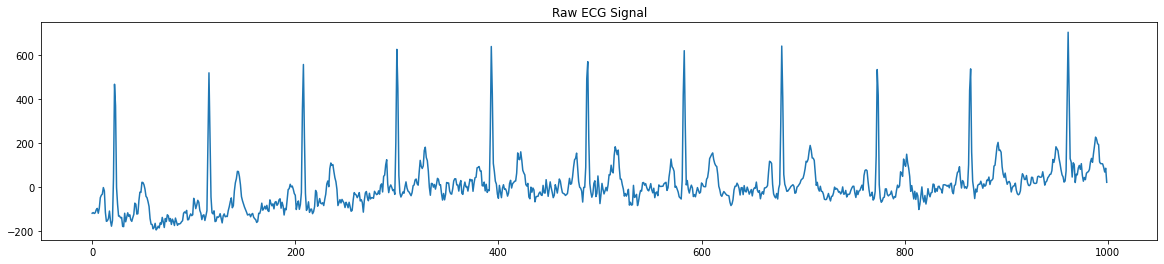

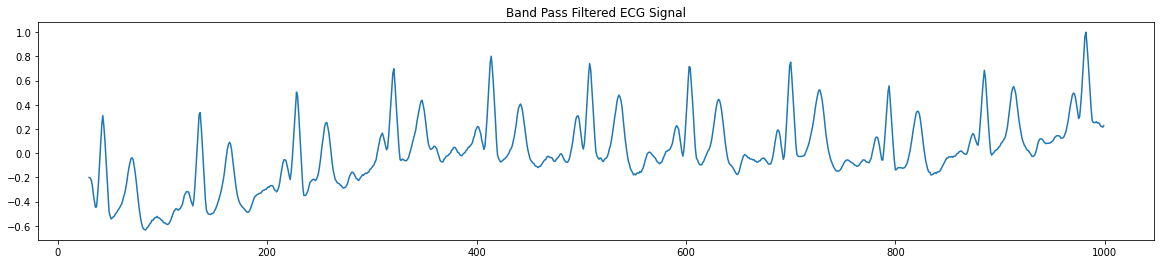

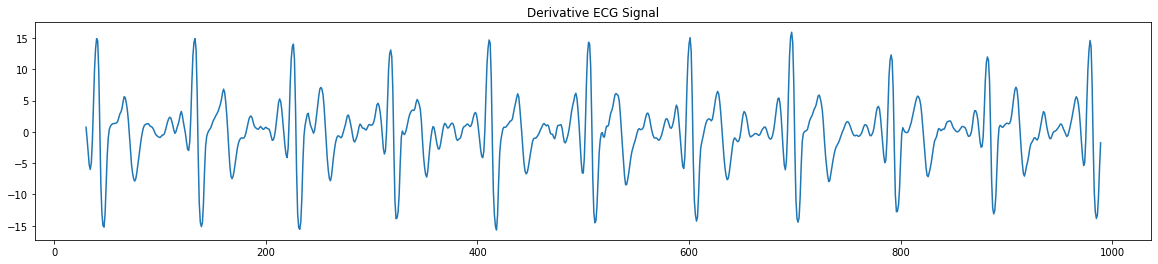

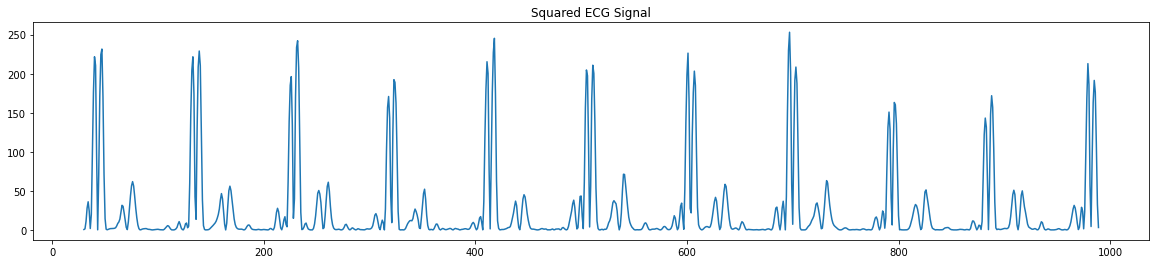

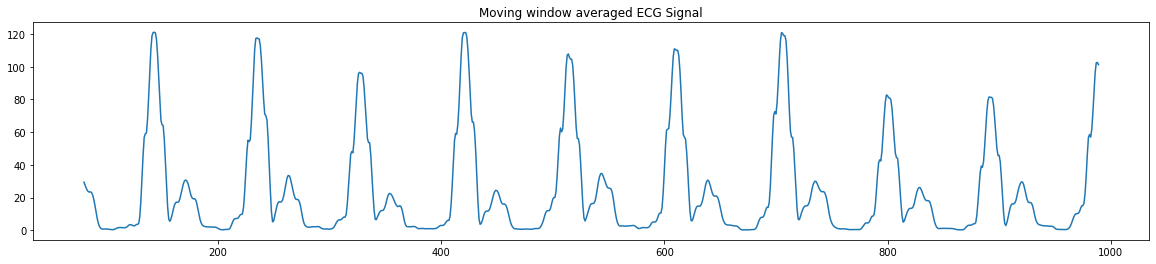

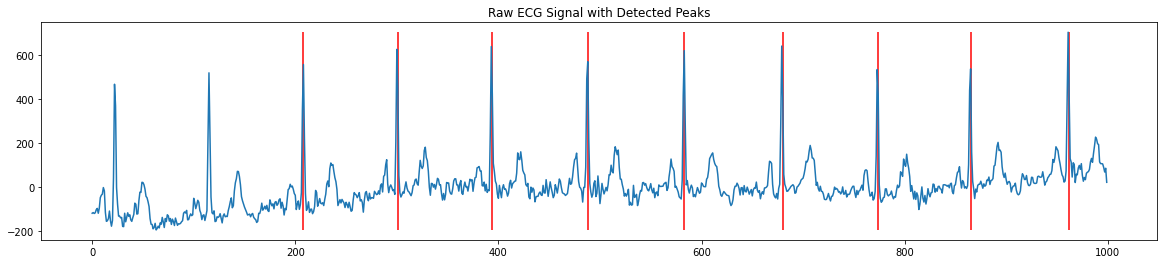

In [ ]:
path = "/content/drive/MyDrive/IDOVEN/Data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/records100/00000/"
patient_ID = "00001"
patient_path = path + patient_ID + "_lr"

record = wfdb.rdrecord(patient_path) 
fs = 100 # frequecy sampling
QRS_detector = Pan_Tompkins_QRS()

ecg = pd.DataFrame(np.array([list(range(len(record.adc()))),record.adc()[:,0]]).T,columns=['TimeStamp','ecg'])

ecg_signal = ecg.iloc[:,1].to_numpy()
time_stamp = ecg.TimeStamp

integration_signal, band_pass_signal, derivative_signal, square_signal  = QRS_detector.solve(ecg_signal.copy())

r_peaks = detect_peaks(ecg_signal, fs)
heart_beat = np.average(np.diff(r_peaks))/ fs
print( '\033[1m' + "Patient ID " + str(patient_ID) + '\033[0m')
print('\033[1m' + "Heart Rate: " + '\033[0m'+ str(60/heart_beat) + " BPM")

plt.figure(figsize=(20,4))
plt.plot(time_stamp, ecg_signal)
plt.title("Raw ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:], band_pass_signal[30:])
plt.title("Band Pass Filtered ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:len(time_stamp)-10], derivative_signal[30:len(time_stamp)-10])
plt.title("Derivative ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:len(time_stamp)-10], square_signal[30:len(time_stamp)-10]) 
plt.title("Squared ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[80:len(time_stamp)-10], integration_signal[80:len(time_stamp)-10]) 
plt.title("Moving window averaged ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp, ecg_signal)    
plt.vlines(r_peaks,ymin = min(ecg_signal), ymax = max(ecg_signal), colors = 'red')
plt.title("Raw ECG Signal with Detected Peaks")
plt.show()


## Applying Machine Learning/Deep Learnig Techniques 

We are going to try machine learning methods on the following signals:


*   Raw ECG
*   Spectogram of the Raw ECG

We will compare the acuruaccy of the model versus the time needed to train both models.

In [ ]:
# Convert ECG Signals into spectograms
ecg_spectogram_short = []
for ecg_raw in ecg_raw_short:
  f, t, Sxx = signal.spectrogram(ecg_raw)
  ecg_spectogram_short.append(f)

ecg_spectogram_short = np.array(ecg_spectogram_short)
ecg_raw_short = np.array(ecg_raw_short)

/usr/local/lib/python3.8/dist-packages/scipy/signal/spectral.py:1964: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  warnings.warn('nperseg = {0:d} is greater than input length '


In [ ]:
# We pass the column diagnostic superclass to a list
Y = Y_short['diagnostic_superclass']
Y = Y.tolist()
Y_new = []
for val in Y:
  Y_new.append(val[0])

# split into train test sets (stratify is used to balance the data)
X_train_spec, X_test_spec, Y_train_spec, Y_test_spec = train_test_split(ecg_spectogram_short, Y_new, test_size=0.10, random_state=1, stratify=Y_new)


nsamples, nx, ny = ecg_raw_short.shape
ecg_raw_short = ecg_raw_short.reshape((nsamples,nx*ny))
X_train_raw, X_test_raw, Y_train_raw, Y_test_raw = train_test_split(ecg_raw_short, Y_new, test_size=0.10, random_state=1, stratify=Y_new)

In [ ]:
# We check it the data is balanced
print("NORM TEST: " + str(Y_test_spec.count('NORM')) + " and NORM TRAIN: " + str(Y_train_spec.count('NORM')))
print("STTC TEST: " + str(Y_test_spec.count('STTC')) + " and STTC TRAIN: " + str(Y_train_spec.count('STTC')))
print("CD TEST: " + str(Y_test_spec.count('CD')) + " and CD TRAIN: " + str(Y_train_spec.count('CD')))
print("MI TEST: " + str(Y_test_spec.count('MI')) + " and MI TRAIN: " + str(Y_train_spec.count('MI')))

NORM TEST: 68 and NORM TRAIN: 617
STTC TEST: 14 and STTC TRAIN: 123
CD TEST: 10 and CD TRAIN: 88
MI TEST: 8 and MI TRAIN: 71


In [ ]:
# To later save and plot the results
list_acc = []
list_data = []


# SPECTOGRAM
# Create pipeline with the MLP classifier
pipe = deepcopy(pipeline.make_pipeline(StandardScaler(), MLPClassifier()))
pipe.fit(X_train_spec, Y_train_spec)

# Predict
Y_pred_spec = pipe.predict(X_test_spec)

# Evaluate the accuracy of the prediction
ac = accuracy_score(Y_test_spec, Y_pred_spec)
list_acc.append(ac*100)
list_data.append('Spectrogram')


In [ ]:
# RAW ECG
# Create pipeline with the MLP classifier
pipe = deepcopy(pipeline.make_pipeline(StandardScaler(), MLPClassifier()))
pipe.fit(X_train_raw, Y_train_raw)

# Predict
Y_pred_raw = pipe.predict(X_test_raw)

# Evaluate the accuracy of the prediction
ac = accuracy_score(Y_test_raw, Y_pred_raw)
list_acc.append(ac*100)
list_data.append('Raw ECG')

In [ ]:
# Initialize data of lists.
data = {'DATA': list_data,
        'ACCURACY': list_acc}
  
# Create DataFrame
df = pd.DataFrame(data)
  
# Print the output.
df   

,DATA,ACCURACY
0,Spectrogram,68.0
1,Raw ECG,51.0


# **ACHIEVEMENTS**

*   To know Physionet, and more specifically the PTB-XL Dataset. 
*   To know specific libraries related to Physionet to load, plot.. signals.
*   To investigate more about ECG and the relevant paper that it has in the heart issues detection.
*   To be more confident with the ECG area.
*   To apply the knowledge acquired during my master studies in the subject Biosignals and Machine Learning.


# **COMMENTS**

During this task, I **has been able to** extract some features from ECG signal, that later will be relevant to detect some anomalies. Anomalies as for example Arrhythmia or any other heart disease. 

Review how the way we are working with the data can affect highly the **time needed to train the models**. In this case, we can see how working with spectograms instead of the raw ECG data can affect a lot the time needed. 


*   Train and predict the spectogram in 0 sec (comvert all ECGs to spectograms 2sec).
*   Train and predict the ECG in 40 sec.


As we can see, this seems to not be a huge difference, but we have to take into account that we are working with a small part of the data and classe,s so if in future we will use the whole data this can affect a lot the time needed. Also it is really important to note that additional step to pass the raw ecg to the spectogram it took 2 sec for all the data we were working with.

In the other hand, if we compare the accuracy with the exact same model, we can see that it is better with the spectogram signal instead of with the raw ecg data. Another reason apart from the time, it is added to choose the spectogram over the raw ecg. 



# **NEXT STEPS** 

* **Test more elaborated and individualized mother machine/deep learning models**
* **Work with all classes**
* **Use ECG images instead of singals to train models:**
This is another point I was thinking of. If doctor uses the ECG plot to detect illness, why not to follow the same path with deep learning?
* **How to introduce Machine Learning/Deep Learning in future steps:**

At first, introduce Machine Learning/Deep Learning to detect automatically the different peaks. In that way we will be able to later on use another Machine Learning/Deep Learning model to detect heart anomalies. 

But, how? This last model as first propposal I will do the following:

Feature Selection: First of all, I will see the correlation between all the features of each signal (age, heart beat, R peak distance...) and the disease/anomalie. In that way, I will be able to see which features are the most relevant in the anomalie detection and we can delete those features that can be adding noise to our model.

Train data, test data and validation data. After evaluating the data that PTB-XL is providing us we can see that there is patients with different anomalies. So, with the aim of obtaining a more accurate results. It is really important to have a balanced data in the model, in other words to have equitative the quantity of patients with each disease in the different sets of data.

Once all these steps have been carried out, we can start to try the different machine learning/deep learning models that exhist nowadays and are in the benchmark. Thank you to those models the patient and doctors will have a positive impact in their lives. As Doctor, this will help to easing the workload giving them more time to focus on the patient. As patient, maybe they will have a faster result of their illness so It can be treated in a fastest way.







# **REFERENCES AND CREDITS** 💳
Pan, J. and Tompkins, W., 1985. A Real-Time QRS Detection Algorithm. IEEE Transactions on Biomedical Engineering, BME-32(3), pp.230-236

Wagner, P., Strodthoff, N., Bousseljot, R., Samek, W., & Schaeffter, T. (2022). PTB-XL, a large publicly available electrocardiography dataset (version 1.0.3). PhysioNet. Link

Subject Biosignals and Bioimages. Master in Information Health Engineering (2019-2020).

Github repositories:
*   https://github.com/MIT-LCP/wfdb-python
*   https://github.com/adityatripathiiit/Pan_Tompkins_QRS_Detection

